In [2]:
from dotenv import load_dotenv; load_dotenv()
import datetime as dt
from datetime import datetime
import requests_cache
import os
import pandas_datareader.data as web
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import requests
import bs4 as bs
import pickle
from sklearn.linear_model import LinearRegression
%matplotlib inline

In [3]:
def get_prices(ticker, start, end):
    '''returns dataframe of adjusted close prices of specified ticker from start to end date'''
    start = datetime(start[0], start[1], start[2])
    end = datetime(end[0], end[1], end[2])
    api_key = os.getenv('ALPHAVANTAGE_API_KEY')
    session = requests_cache.CachedSession()

    prices = web.DataReader(ticker, 'av-daily-adjusted', start, end, api_key=api_key, session=session)
    prices = prices[['close']]
    prices.columns = [ticker]

    return prices

In [4]:
def get_all_prices(tickers, start, end):
    '''returns dataframe containing adjusted close prices of all specified tickers'''
    prices = []
    for ticker in tickers:
        try:
            prices.append(get_prices(ticker, start, end))
        except KeyError:
            pass
    return pd.concat(prices, axis=1)

In [5]:
def get_n_day_returns(prices, n=1):
    '''takes in prices df and n and returns n-day forward return df'''
    returns = (prices.shift(-n) / prices) - 1
    returns = returns[:-n]
    return returns

In [6]:
def get_signal_data(file_name, s, e):
    '''takes in file name, start, end dates as tuples and returns df containing signal data'''
    data = pd.read_csv(file_name, index_col='date')
    start = dt.datetime(s[0], s[1], s[2])
    end = dt.datetime(e[0], e[1], e[2])
    data.index = pd.to_datetime(data.index)
    data = data.loc[start:end]
    return data


In [7]:
def generate_rsi_data(prices, period=14):
    '''creates rsi df using price df given and specified period length'''
    # i think this is accurate?
    # look at tradingview implementation of rsi later
    data = prices.copy()
    data = data.diff()
    data = data[1:]
    up = data.copy()
    down = data.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    roll_up = up.rolling(period).mean()
    roll_down = down.abs().rolling(period).mean()
    rs = roll_up / roll_down
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi.dropna()

In [8]:
def generate_dix_gex_backtest():
    data = pd.read_csv('DIX.csv')
    # normalize dix and gex columns
    data['dix'] = ((data['dix']-data['dix'].min())/(data['dix'].max()-data['dix'].min()))
    data['gex'] = ((data['gex']-data['gex'].min())/(data['gex'].max()-data['gex'].min()))
    data['dix - gex'] = data['dix'] - data['gex']
    data['dix - gex'] = ((data['dix - gex']-data['dix - gex'].min())/(data['dix - gex'].max()-data['dix - gex'].min()))
    data['dix - gex decile'] = pd.qcut(data['dix - gex'], 10, labels=False)
    data['dix - gex decile'] = data['dix - gex decile'] + 1
    data['60 day fwd return'] = get_n_day_returns(data['price'], n=60)
    data.drop(['dix', 'dix - gex decile'], axis=1, inplace=True)
    data = data[:-60]
    data.sort_values('dix - gex', inplace=True)
    x = data.iloc[:, 2].values.reshape(-1, 1)
    y = data.iloc[:, 4].values.reshape(-1, 1)
    linear_regressor = LinearRegression()
    linear_regressor.fit(x, y)
    y_prediction = linear_regressor.predict(x)
    plt.scatter(x, y)
    plt.plot(x, y_prediction, color='red')
    plt.show()
    print(linear_regressor.coef_)
    return data

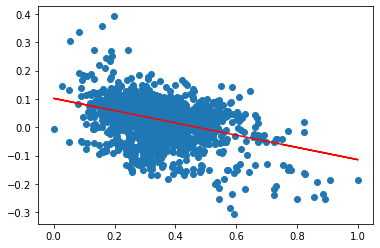

[[-0.21642288]]


,date,price,gex,dix - gex,60 day fwd return
0,2011-05-02,1361.219971,0.334306,0.365632,-0.041382
1,2011-05-03,1356.619995,0.331719,0.384172,-0.041242
2,2011-05-04,1347.319946,0.321944,0.422964,-0.040851
3,2011-05-05,1335.099976,0.297442,0.489143,-0.036072
4,2011-05-06,1340.199951,0.306286,0.531053,-0.064281
...,...,...,...,...,...
2268,2020-05-07,2881.190000,0.584767,0.473979,0.143493
2269,2020-05-08,2929.800000,0.462176,0.501065,0.128579
2270,2020-05-11,2930.190000,0.458043,0.629262,0.135684
2271,2020-05-12,2870.120000,0.422015,0.620888,0.166906


In [9]:
def run_dix_gex_simulation():
    data = generate_dix_gex_backtest()
    data.sort_index(inplace=True)
    return data
run_dix_gex_simulation()

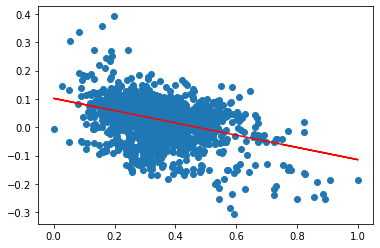

[[-0.21642288]]


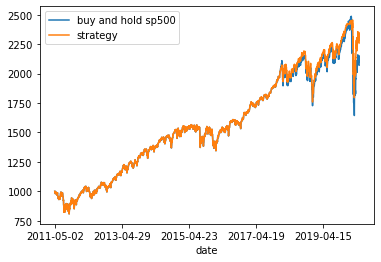

,date,price,gex,position,hold,strat
date,,,,,,
2011-05-02,2011-05-02,1361.219971,0.000000,1.000000,1000.000000,1000.000000
2011-05-03,2011-05-03,1356.619995,0.336563,1.000000,996.620696,996.620696
2011-05-04,2011-05-04,1347.319946,0.356111,1.000000,989.788553,989.788553
2011-05-05,2011-05-05,1335.099976,0.405117,1.000000,980.811334,980.811334
2011-05-06,2011-05-06,1340.199951,0.387428,1.000000,984.557955,984.557955
...,...,...,...,...,...,...
2020-05-07,2020-05-07,2881.190000,-0.169534,1.000000,2116.623368,2309.934323
2020-05-08,2020-05-08,2929.800000,0.075649,0.983047,2152.333982,2348.245672
2020-05-11,2020-05-11,2930.190000,0.083914,0.990611,2152.620489,2348.555324


In [16]:
def simulate_portfolio():
    capital = 1000
    #position = .5

    data = run_dix_gex_simulation()
    #data.index = data['date']
    data.drop(['dix - gex', '60 day fwd return'], axis=1, inplace=True)
    data['gex'] = (((data['gex'] * 2) - 1) * -1)
    data['position'] = 0
    data['addpos'] = (data['gex'].shift(1) / 10)
    data['addpos'] = data['addpos'].apply(lambda x: 1 if (x > 1) else x)
    data['position'] = data['position'] + data['position'].shift(1)
    data['position'] = data['addpos']
    data.drop(['addpos'], inplace=True, axis=1)
    data.iloc[0, 2] = 0
    #data['position'] += .5
    data.iloc[0, 3] = 1
    for i in range(1, 2273):
        if (data.iloc[i, 3] + data.iloc[i - 1, 3]) > 1:
            data.iloc[i, 3] = 1
        else:
            data.iloc[i, 3] = data.iloc[i - 1, 3] + data.iloc[i, 3]
        if (data.iloc[i, 3] < 0):
            data.iloc[i, 3] = 0
    data['hold'] = capital
    data['strat'] = capital
    for i in range(1, 2273):
        data.iloc[i, 4] = data.iloc[i - 1, 4] + (data.iloc[i - 1, 4] * ((data.iloc[i, 1] - data.iloc[i - 1, 1]) / data.iloc[i - 1, 1]))
        data.iloc[i, 5] = data.iloc[i - 1, 5] + (data.iloc[i - 1, 5] * data.iloc[i, 3] * ((data.iloc[i, 1] - data.iloc[i - 1, 1]) / data.iloc[i - 1, 1]))
    data.index = data['date']
    data['hold'].plot()
    data['strat'].plot()
    plt.legend(['buy and hold sp500', 'strategy'])
    plt.show()
    #testing
    #print(data.to_string())
    return data
simulate_portfolio()




In [11]:
def generate_quantiles(prices, n=5):
    '''puts each stock into quantile for each day based on signal score'''
    data = generate_rsi_data(prices)
    # try to refactor this, loops aren't good
    for i, x in enumerate(data.index):
        data.iloc[i] = pd.qcut(data.iloc[i], n, labels=[str(i + 1) for i in range(n)])
    return data

In [12]:
def generate_backtest(quantiles, returns, n=5):
    '''generates backtest data from quantiles and returns data'''
    data = quantiles.copy()
    data = data[:-1]
    quantiles = quantiles[:-1]
    data.columns = [i + 1 for i in range(n)]
    for date in quantiles.index:
        for ticker in quantiles.columns:
            quantile = int(quantiles.loc[date, ticker])
            data.loc[date, quantile] = returns.loc[date, ticker]
    data.index = pd.to_datetime(data.index)
    data = data + 1
    data = data.cumprod()
    data.plot()
    return data

In [13]:
def get_sp500_tickers():
    '''pulls list of sp500 tickers'''
    # sort of works, try to implement later
    tickers = []
    res = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(res.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        tickers.append(ticker)
        
    with open("sp500tickers.pickle","wb") as f:
        pickle.dump(tickers,f)

    new_tickers = []
    for ticker in tickers:
        new_tickers.append(ticker.rstrip())
        
    return new_tickers

In [14]:
# testing stuff
'''tickers = ['AAPL', 'JBLU', 'JPM', 'AMZN', 'TGT']
start = (2015, 1, 5)
end = (2015, 6, 5)
quantiles = 5
prices = get_all_prices(tickers, start, end)
returns = get_n_day_returns(prices)
quantiles = generate_quantiles(prices, 5)
generate_backtest(quantiles, returns, 5)'''

"tickers = ['AAPL', 'JBLU', 'JPM', 'AMZN', 'TGT']\nstart = (2015, 1, 5)\nend = (2015, 6, 5)\nquantiles = 5\nprices = get_all_prices(tickers, start, end)\nreturns = get_n_day_returns(prices)\nquantiles = generate_quantiles(prices, 5)\ngenerate_backtest(quantiles, returns, 5)"